<a href="https://www.kaggle.com/code/dalao1002/mnist-digit-recognizer?scriptVersionId=164447621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import platform
import sys
import random

# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# plot
import matplotlib
import matplotlib.pyplot as plt
# machine learning
import sklearn
# deep learning
import torch
import torchvision

In [2]:
print("Operating system: ", platform.platform(), platform.version())
print("Python version", sys.version)
print("Pandas version: ", pd.__version__)
print("Matplotlib version: ", matplotlib.__version__)
print("Sklearn version: ", sklearn.__version__)
print("Pytorch version: ", torch.__version__)

Operating system:  Linux-5.15.133+-x86_64-with-glibc2.31 #1 SMP Tue Dec 19 13:14:11 UTC 2023
Python version 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
Pandas version:  2.2.0
Matplotlib version:  3.7.4
Sklearn version:  1.2.2
Pytorch version:  2.1.2+cpu


In [3]:
# reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print('Using device:', device)

Using device: cpu


In [5]:
TARGET = "label"
RANDOM_STATE = 0
TRAIN_VS_VALIDATION_SET_PERCENTANGE = 0.8
BATCH_SIZE = 16
NUMBER_OF_EPOCHS = 14

In [6]:
# Input data files are available in the read-only "../input/" directory
dataset_train_full_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv",dtype = np.float32)
X_test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv",dtype = np.float32)
# Separate target from features
X_train_full_df = dataset_train_full_df.drop([TARGET], axis=1)
y_train_full_s = dataset_train_full_df[TARGET]

In [7]:
mean = 0.1307
std = 0.3081
X_train_full_np = (X_train_full_df.to_numpy().reshape(-1, 1, 28, 28)/255-mean)/std
X_train_full_tf = torch.from_numpy(X_train_full_np)
X_test_np = (X_test_df.to_numpy().reshape(-1, 1, 28, 28)/255-mean)/std
X_test_tf = torch.from_numpy(X_test_np)
y_train_full_tf = torch.from_numpy(y_train_full_s.to_numpy(dtype="int"))
y_train_full_tf_onehot = torch.nn.functional.one_hot(y_train_full_tf).float()

In [8]:
from sklearn.model_selection import train_test_split

# Break off validation set from training data
X_train_tf, X_valid_tf, y_train_tf_onehot, y_valid_tf_onehot = train_test_split(
    X_train_full_tf, y_train_full_tf_onehot,
    train_size=TRAIN_VS_VALIDATION_SET_PERCENTANGE,
    # shuffle the dataset to ensure the traning set is representive of the overall distribution of the data,
    # this would be useful e.g. the input is sorted by target label or specific feature.
    shuffle=True,
    random_state=RANDOM_STATE
)

In [9]:
def display_img(img):
    PIL_RGB_image = img.permute(1, 2, 0)
    img = (PIL_RGB_image * std + mean)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)

tensor(6)


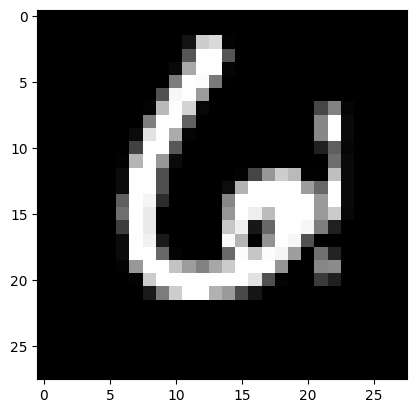

In [10]:
display_img(X_train_tf[0])
print(y_train_tf_onehot[0].argmax())

In [11]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tf, y_train_tf_onehot)
valid_dataset = TensorDataset(X_valid_tf, y_valid_tf_onehot)
g = torch.Generator()
g.manual_seed(0)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False, generator=g)

In [12]:
# https://github.com/pytorch/examples/blob/main/mnist/main.py
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(7744, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [13]:
import torch.optim as optim

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

In [14]:
count = 0
loss_evolution = []
for epoch in range(NUMBER_OF_EPOCHS):
    epoch_loss = 0
    for batch_index, batch in enumerate(train_loader):
        sample_images, sample_labels = batch
        optimizer.zero_grad()
        predicted_labels = model(sample_images)
        loss = criterion(predicted_labels, sample_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    print(epoch_loss)

tensor(552.9968, grad_fn=<AddBackward0>)
tensor(241.4821, grad_fn=<AddBackward0>)
tensor(184.4321, grad_fn=<AddBackward0>)
tensor(162.4894, grad_fn=<AddBackward0>)
tensor(130.1953, grad_fn=<AddBackward0>)
tensor(125.9625, grad_fn=<AddBackward0>)
tensor(115.7409, grad_fn=<AddBackward0>)
tensor(106.3082, grad_fn=<AddBackward0>)
tensor(90.9056, grad_fn=<AddBackward0>)
tensor(81.9197, grad_fn=<AddBackward0>)
tensor(85.9497, grad_fn=<AddBackward0>)
tensor(80.6161, grad_fn=<AddBackward0>)
tensor(81.9910, grad_fn=<AddBackward0>)
tensor(89.0020, grad_fn=<AddBackward0>)


In [15]:
y_test_pred_tf_onehot = model(X_test_tf)
y_test_pred_tf = y_test_pred_tf_onehot.argmax(axis=1)

In [16]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.DataFrame(y_test_pred_tf, columns = ['Label'])
df.index.name='ImageId'
df.index += 1
df.to_csv('/kaggle/working/results.csv', header=True)